In [1]:
%matplotlib widget
import scipy
import starepandas
import pandas
import modreaders
import glob
import multiprocessing
import itertools
import numpy
import pickle
import matplotlib.pyplot as plt
import contextily
import copy

In [2]:
starepandas.__version__

'0.6.2'

# Gridded

## Small

In [4]:
# small
x_min = 1353
x_max = 1402
y_min = 552
y_max = 575

# big
x_min = 1346
x_max = 1427
y_min = 535
y_max = 578

# Huge
x_min = 1294
x_max = 1430
y_min = 532
y_max = 619

bbox = (x_min, x_max, y_min, y_max)

## Test Read

In [5]:
f = '/tablespace/spires/2017-12-11/MOD09GA.A2017345.h08v05.006.2017347024314.hdf'
t = modreaders.read_mod09ga(f, bbox, sidecar_path='data/h08v05_stare.nc')
t[(t.x==1366) & (t.y==569)]

,lat,lon,sids,ts_start,ts_end,x,y,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,...,QC_500m_1,obscov_500m_1,state_1km_1,SensorZenith_1,cloud,cloud_shadow,cloud_internal,snow_mod35,snow_internal,modland_qa
1366966,37.627083,-119.07338,3330892550301984942,2017-12-11 17:45:00,2017-12-11 19:30:00,1366,569,0.0313,0.1719,0.007,...,1073741824,0.12,8396,52.43,0,True,False,False,False,0


## Read all Tiles

In [6]:
%%time
file_paths = glob.glob('/tablespace/spires/mod09ga/*.hdf')
n_processes = 32
with multiprocessing.Pool(processes=n_processes) as pool:
    mod09ga = pool.starmap(modreaders.read_mod09ga, zip(file_paths, itertools.repeat(bbox)))
mod09ga = pandas.concat(mod09ga)
mod09ga.reset_index(drop=True, inplace=True)

CPU times: user 27.8 s, sys: 37.9 s, total: 1min 5s
Wall time: 2h 15min 37s


In [7]:
def add_ndvi(df):
    ndvi = (df['sur_refl_b02_1'] - df['sur_refl_b01_1'])/(df['sur_refl_b02_1'] + df['sur_refl_b01_1'])
    df['ndvi'] = ndvi
    
def add_ndsi(df):
    ndsi = (df['sur_refl_b04_1'] - df['sur_refl_b06_1'])/(df['sur_refl_b04_1'] + df['sur_refl_b06_1'])
    df['ndsi'] = ndsi

add_ndsi(mod09ga)
add_ndvi(mod09ga)

In [8]:
mod09ga['total_brightness'] = mod09ga[['sur_refl_b01_1', 'sur_refl_b02_1', 'sur_refl_b03_1', 'sur_refl_b04_1', 'sur_refl_b05_1', 'sur_refl_b06_1', 'sur_refl_b07_1']].sum(axis=1)

## 2019

In [9]:
mod09ga_2019 = copy.copy(mod09ga)
#mod09ga_2019 = mod09ga_2019[mod09ga_2019['cloud_internal']==False] 
#mod09ga_2019 = mod09ga_2019[mod09ga_2019['sur_refl_b03_1']>=0.01] 
mod09ga_2019 = mod09ga_2019[(mod09ga_2019['ts_start'] >= '2019-01-01') & (mod09ga_2019['ts_start'] <= '2019-12-31')]
mod09ga_2019 = mod09ga_2019[mod09ga_2019['modland_qa']==0]

grouped = mod09ga_2019.groupby(['x','y'])
r0_2019 = []
for group in grouped.groups:
    selected = grouped.get_group(group)   
    selected = selected[selected['sur_refl_b03_1']==selected['sur_refl_b03_1'].min()]
    selected = selected[selected['cloud_internal']==selected['cloud_internal'].min()]
    #selected = selected[selected['ndvi']==selected['ndvi'].max()]
    selected = selected[selected['total_brightness']==selected['total_brightness'].min()]
    r0_2019.append(selected.iloc[0:1])
r0_2019 = pandas.concat(r0_2019)

### Verify 2019

In [10]:
def find_cell(ifovs, spectrum):
    rows = ifovs[(numpy.isclose(ifovs['sur_refl_b01_1'], spectrum[0], atol=1e-04)) & 
                 (numpy.isclose(ifovs['sur_refl_b02_1'], spectrum[1], atol=1e-04)) & 
                 (numpy.isclose(ifovs['sur_refl_b03_1'], spectrum[2], atol=1e-04)) & 
                 (numpy.isclose(ifovs['sur_refl_b04_1'], spectrum[3], atol=1e-04)) & 
                 (numpy.isclose(ifovs['sur_refl_b05_1'], spectrum[4], atol=1e-04)) & 
                 (numpy.isclose(ifovs['sur_refl_b06_1'], spectrum[5], atol=1e-04)) & 
                 (numpy.isclose(ifovs['sur_refl_b07_1'], spectrum[6], atol=1e-04)) ]
    return rows

In [11]:
r0_grid_raw = scipy.io.loadmat('data/h08v05_R0.mat')['R0']
r0_grid_raw = numpy.swapaxes(r0_grid_raw, 0,1 )

In [12]:
# Cells where Timbos and my r0 don't match
for index, row in r0_2019.set_index(['x', 'y']).iterrows():    
    x = index[0]
    y = index[1]
    if not numpy.isclose(row['sur_refl_b01_1'], r0_grid_raw[x, y, 0], atol=1e-03):        
        print(x, y, row['sur_refl_b01_1'], r0_grid_raw[x, y, 0])

1294 575 0.0204 0.010999999940395355
1294 576 0.0303 0.010999999940395355
1294 603 0.0425 0.012199999764561653
1294 605 0.0138 0.012199999764561653
1295 575 0.0203 0.011300000362098217
1296 573 0.0192 0.011300000362098217
1296 574 0.0266 0.011300000362098217
1297 545 0.0052 0.0017999999690800905
1297 574 0.0266 0.011300000362098217
1297 576 0.0419 0.02280000038444996
1298 544 0.0059 0.0013000000035390258
1298 561 0.0303 0.047200001776218414
1298 568 0.0392 0.042399998754262924
1299 543 0.004 0.0013000000035390258
1300 593 0.0213 0.03189999982714653
1301 579 0.0471 0.04879999905824661
1301 616 0.0109 0.03750000149011612
1302 543 0.0052 0.0017000000225380063
1302 589 0.0315 0.027300000190734863
1303 541 0.0127 0.0010999999940395355
1303 542 0.0056 0.0005000000237487257
1303 543 0.0059 0.0006000000284984708
1303 544 0.0096 0.011599999852478504
1304 541 0.0056 0.0005000000237487257
1304 542 0.0042 0.0008999999845400453
1304 545 0.0206 9.999999747378752e-05
1305 541 0.0062 0.000899999984540

In [25]:
# All the observations at this cell in 2019
x = 1430
y = 533

mod09ga_2019[(mod09ga_2019.x==x) & (mod09ga_2019.y==y) &(mod09ga_2019.sur_refl_b03_1>0.00)].sort_values('sur_refl_b03_1')

,ts_start,ts_end,x,y,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,...,SensorZenith_1,cloud,cloud_shadow,cloud_internal,snow_mod35,snow_internal,modland_qa,ndsi,ndvi,total_brightness
39818435,2019-08-04 00:00:00,2019-08-04 23:59:59,1430,533,0.0370,0.1565,0.0092,0.0300,0.1537,0.1362,...,46.75,0,False,False,False,False,0.0,-0.638989,0.617571,0.6019
10532254,2019-07-28 00:00:00,2019-07-28 23:59:59,1430,533,0.0205,0.0550,0.0136,0.0197,0.0660,0.0528,...,39.73,0,True,False,False,False,0.0,-0.456552,0.456954,0.2569
47344102,2019-09-19 00:00:00,2019-09-19 23:59:59,1430,533,0.0388,0.1921,0.0140,0.0314,0.1814,0.1273,...,57.41,1,False,True,False,False,0.0,-0.604285,0.663924,0.6559
58310867,2019-07-05 00:00:00,2019-07-05 23:59:59,1430,533,0.0511,0.1621,0.0194,0.0407,0.1683,0.1667,...,31.32,1,False,True,False,False,0.0,-0.607522,0.520638,0.7071
37596518,2019-11-06 00:00:00,2019-11-06 23:59:59,1430,533,0.0419,0.1804,0.0197,0.0354,0.1725,0.1153,...,57.41,0,False,False,False,False,0.0,-0.530192,0.623032,0.6321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81959243,2019-05-31 17:00:00,2019-05-31 20:20:00,1430,533,0.9247,0.9099,0.9139,0.9122,0.7030,0.4002,...,23.90,1,False,True,False,False,0.0,0.390125,-0.008067,5.0023
24163424,2019-02-10 18:25:00,2019-02-10 20:10:00,1430,533,0.9002,0.8843,0.9212,0.8974,0.7693,0.3502,...,42.02,1,False,True,False,False,0.0,0.438602,-0.008910,4.9603
44938649,2019-12-04 00:00:00,2019-12-04 23:59:59,1430,533,0.8957,0.8866,0.9233,0.8982,0.7165,0.3530,...,48.83,1,False,True,False,False,0.0,0.435742,-0.005106,4.8946
60186948,2019-02-02 17:35:00,2019-02-02 19:20:00,1430,533,1.0409,1.0316,1.0432,1.0400,0.7524,0.4258,...,39.63,1,False,True,False,False,0.0,0.419020,-0.004487,5.5959


In [26]:
# The one timbo selected
find_cell(mod09ga, r0_grid_raw[x, y])

,ts_start,ts_end,x,y,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,...,SensorZenith_1,cloud,cloud_shadow,cloud_internal,snow_mod35,snow_internal,modland_qa,ndsi,ndvi,total_brightness
39818433,2019-08-04,2019-08-04 23:59:59,1428,533,0.037,0.1565,0.0092,0.03,0.1537,0.1362,...,46.65,0,False,True,False,False,0.0,-0.638989,0.617571,0.6019
39818434,2019-08-04,2019-08-04 23:59:59,1429,533,0.037,0.1565,0.0092,0.03,0.1537,0.1362,...,46.65,0,False,True,False,False,0.0,-0.638989,0.617571,0.6019
39818435,2019-08-04,2019-08-04 23:59:59,1430,533,0.037,0.1565,0.0092,0.03,0.1537,0.1362,...,46.75,0,False,False,False,False,0.0,-0.638989,0.617571,0.6019


In [28]:
# The one I selected
r0_2019[(r0_2019.x==x)& (r0_2019.y==y)]

,ts_start,ts_end,x,y,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,...,SensorZenith_1,cloud,cloud_shadow,cloud_internal,snow_mod35,snow_internal,modland_qa,ndsi,ndvi,total_brightness
39818435,2019-08-04,2019-08-04 23:59:59,1430,533,0.037,0.1565,0.0092,0.03,0.1537,0.1362,...,46.75,0,False,False,False,False,0.0,-0.638989,0.617571,0.6019


In [16]:
with open('/tablespace/spires/r0/r0_grid_2019.pickle', 'wb') as f:
    pickle.dump(r0_2019, f)

## All

In [29]:
r0_filtered = mod09ga
r0_filtered = r0_filtered[r0_filtered['SensorZenith_1']<30] 

grouped = r0_filtered.groupby(['x','y'])
r0 = []
for group in grouped.groups:    
    g = grouped.get_group(group)
    if g['ndsi'].min() > 0:
        selected = g
        selected = selected[selected['sur_refl_b03_1']>0.1] 
        selected = selected[selected['sur_refl_b03_1'] == selected['sur_refl_b03_1'].min()]
    else:        
        selected = g
        selected = selected[selected['cloud_shadow']==False]
        selected = selected[selected['cloud_internal']==False] 
        selected = selected[selected['snow_internal']==False] 
        selected = selected[selected['snow_mod35']==False]         
        selected = selected[selected['ndvi'] == selected['ndvi'].max()]
        selected = selected[0:1]
    r0.append(selected)
r0 = pandas.concat(r0)
r0.reset_index(drop=True, inplace=True)

In [30]:
with open('/tablespace/spires/r0/r0_grid.pickle', 'wb') as f:
    pickle.dump(r0, f)

# MOD09

In [2]:
with open('/tablespace/spires/mod09.pickle', 'rb') as f:
    mod09 = pickle.load(f)

def add_ndvi(df):
    ndvi = (df['500m Surface Reflectance Band 2'] - df['500m Surface Reflectance Band 1'])/(df['500m Surface Reflectance Band 2'] + df['500m Surface Reflectance Band 1'])
    df['ndvi'] = ndvi
    
def add_ndsi(df):
    ndsi = (df['500m Surface Reflectance Band 4'] - df['500m Surface Reflectance Band 6'])/(df['500m Surface Reflectance Band 4'] + df['500m Surface Reflectance Band 6'])
    df['ndsi'] = ndsi

add_ndsi(mod09)
add_ndvi(mod09)
mod09 = mod09.rename(columns={'x': 'scan_pos', 'y': 'track_pos'})

In [29]:
a = mod09.groupby('sids14').get_group(3330880350753652750)

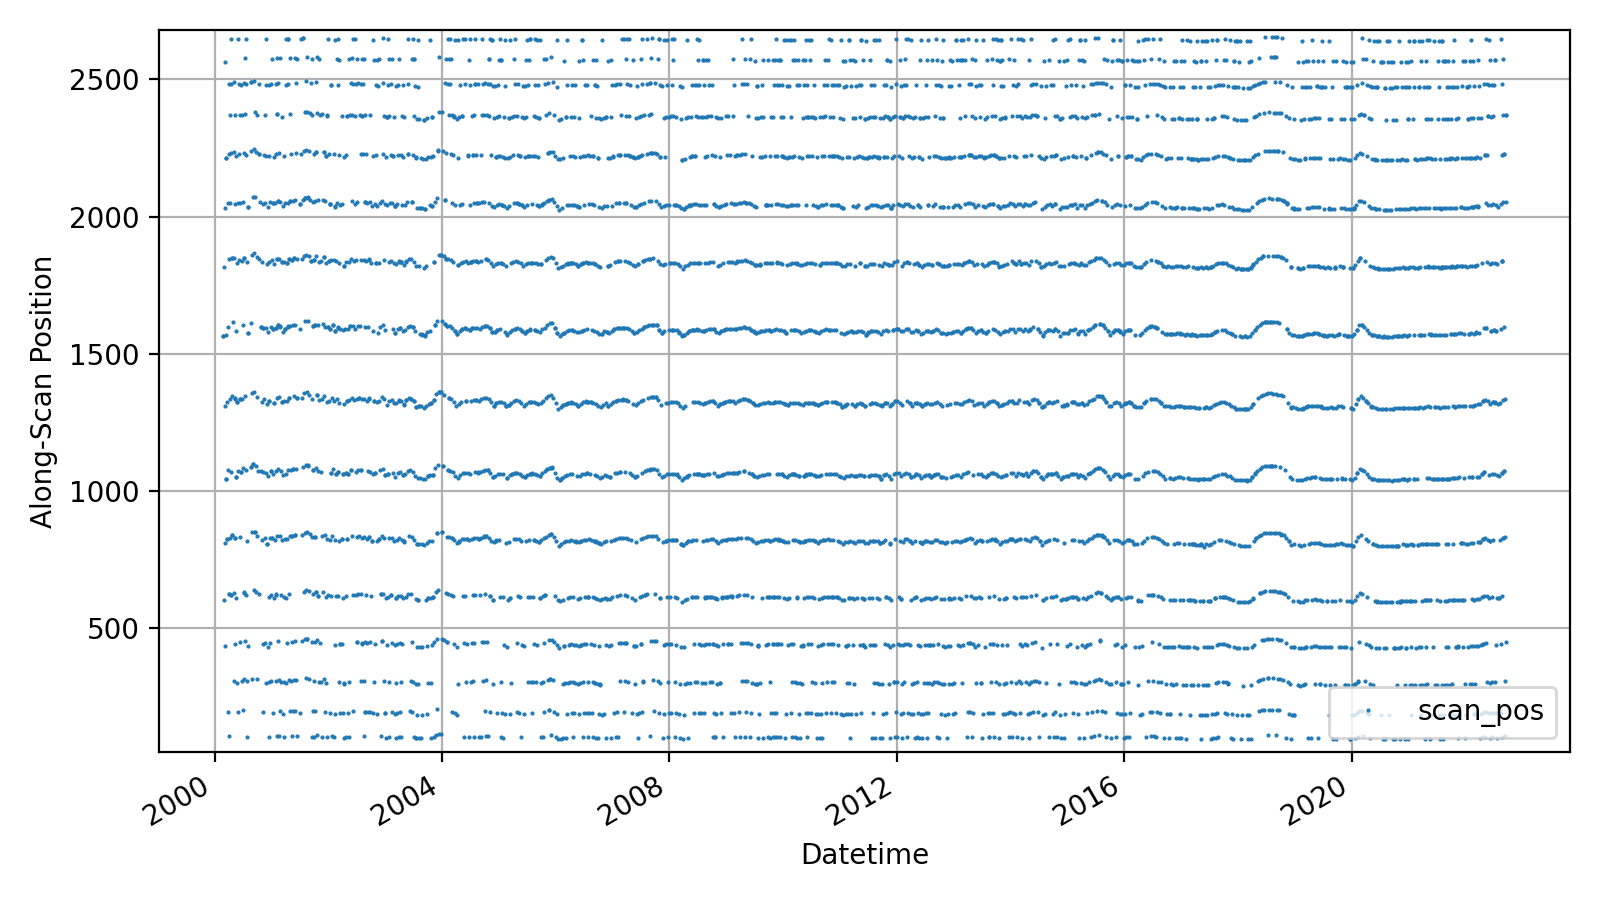

In [35]:
fig = plt.figure(figsize=(8, 4.5), dpi=200)
ax = fig.add_subplot()

pandas.DataFrame(a).plot(ax=ax, y='scan_pos', x='ts_start', linewidth=0, markersize=1, marker='.', grid=True)
ax.set_xlabel("Datetime")
ax.set_ylabel("Along-Scan Position")
ax.set_ylim(50, 2680)

fig.tight_layout()

In [4]:
mod09 = copy.copy(mod09[mod09.modland_qa==0])
mod09.reset_index(inplace=True, drop=True)

In [5]:
mod09['total_brightness'] = mod09.filter(regex='500m Surface').sum(axis=1)

## Subsetting

- Subsetting migth be usefull if we want to get the minimum size of the groups.
- But possibly not advisable since we need the observations at the edge because of overlap from the grid
- We'd subsetting at level 19 to ROI 

In [6]:
with open('data/roi_4326_buffer_huge.pickle', 'rb') as f:
    roi = pickle.load(f)
roi_sids = roi.sids.iloc[0]

subset=False
if subset:
    mod09 = copy.copy(mod09[mod09.to_stare_level(19).stare_intersects(roi.sids.iloc[0], n_partitions=6400)])

## Making R0

In [7]:
def get_best_r0(group_name):            
    g = grouped.get_group(group_name)
    
    if g['ndsi'].min() > 0:
        selected = g
        selected = selected[selected['500m Surface Reflectance Band 3']>0.1] 
        selected = selected[selected['500m Surface Reflectance Band 3'] == selected['500m Surface Reflectance Band 3'].min()]
        selected = selected[0:1]
    else:    
        selected = g        
        #selected = selected[selected['500m Surface Reflectance Band 3']==selected['500m Surface Reflectance Band 3'].min()]
        #selected = selected[selected['cloud_internal']==selected['cloud_internal'].min()]        
        #selected = selected[selected['total_brightness']==selected['total_brightness'].min()]
                        
        selected = selected[selected['cloud_shadow']==False]
        selected = selected[selected['cloud_internal']==False] 
        selected = selected[selected['snow_internal']==False] 
        selected = selected[selected['snow_mod35']==False]         
        selected = selected[selected['ndvi'] == selected['ndvi'].max()]
        selected = selected[0:1]
    return selected

In [17]:
def process_grouped(grouped, level):
    n_processes=64
    with multiprocessing.Pool(processes=n_processes) as pool:
        r0 = pool.map(get_best_r0, list(grouped.groups.keys()))
    r0 = pandas.concat(r0)
    r0.reset_index(drop=True, inplace=True)
    r0['sids'] = r0[f'sids{level}']        
    return r0

In [9]:
nx = 2708
def make_r0(level, nx_bins):    
    global grouped
    if nx_bins > 1:    
        mod09['scan_bin'] = (round(mod09['scan_pos'] / nx * (nx_bins-1)) * nx/(nx_bins-1)).astype('u2')
        grouped = mod09.groupby([f'sids{level}', 'scan_bin'])
    else:            
        grouped = mod09[mod09['SensorZenith']<30].groupby(f'sids{level}')
    print(f'level: {level}; nx_bins: {nx_bins}; max_size: {grouped.size().max()}, min_size: {grouped.size().min()}')
    r0 = process_grouped(grouped, level)
    return r0

In [ ]:
%%time
for level in [14,15,16,17]:    
    for nx_bins in [1,2,3,4,5,6,7]:
        if level>15 and nx_bins>4:
            continue
        r0 = make_r0(level, nx_bins)
        with open(f'/tablespace/spires/r0/r0_stare{level}_{nx_bins}.pickle', 'wb') as f:            
            pickle.dump(r0, f)

level: 14; nx_bins: 1; max_size: 3083, min_size: 2677
level: 14; nx_bins: 2; max_size: 4312, min_size: 1
level: 14; nx_bins: 3; max_size: 3184, min_size: 1
level: 14; nx_bins: 4; max_size: 2617, min_size: 1
level: 14; nx_bins: 5; max_size: 1968, min_size: 1
level: 14; nx_bins: 6; max_size: 1865, min_size: 1
level: 14; nx_bins: 7; max_size: 1585, min_size: 1
level: 15; nx_bins: 1; max_size: 839, min_size: 634
level: 15; nx_bins: 2; max_size: 1119, min_size: 1
level: 15; nx_bins: 3; max_size: 839, min_size: 1
level: 15; nx_bins: 4; max_size: 691, min_size: 1
level: 15; nx_bins: 5; max_size: 544, min_size: 1
level: 15; nx_bins: 6; max_size: 505, min_size: 1
level: 15; nx_bins: 7; max_size: 427, min_size: 1


# VNP09

In [12]:
with open('/tablespace/spires/vnp09.pickle', 'rb') as f:
    vnp09 = pickle.load(f)

def add_ndvi(df):
    ndvi = (df['750m Surface Reflectance Band M7'] - df['750m Surface Reflectance Band M5'])/(df['750m Surface Reflectance Band M7'] + df['750m Surface Reflectance Band M5'])
    df['ndvi'] = ndvi
    
def add_ndsi(df):
    ndsi = (df['750m Surface Reflectance Band M4'] - df['750m Surface Reflectance Band M10'])/(df['750m Surface Reflectance Band M4'] + df['750m Surface Reflectance Band M10'])
    df['ndsi'] = ndsi

add_ndsi(vnp09)
add_ndvi(vnp09)
#mod09 = mod09.rename(columns={'x': 'scan_pos', 'y': 'track_pos'})

In [25]:
def get_best_r0(group_name):            
    g = grouped.get_group(group_name)
    
    if g['ndsi'].min() > 0:
        selected = g
        selected = selected[selected['750m Surface Reflectance Band M3']>0.1] 
        selected = selected[selected['750m Surface Reflectance Band M3'] == selected['750m Surface Reflectance Band M3'].min()]
        selected = selected[0:1]
    else:    
        selected = g        
        selected = selected[selected['cloud']=='00']
        selected = selected[selected['shadow']==False]         
        selected = selected[selected['ndvi'] == selected['ndvi'].max()]
        selected = selected[0:1]
    return selected

In [26]:
nx = 3200
def make_r0(level, nx_bins):    
    global grouped
    if nx_bins > 1:    
        mod09['scan_bin'] = (round(mod09['scan_pos'] / nx * (nx_bins-1)) * nx/(nx_bins-1)).astype('u2')
        grouped = mod09.groupby([f'sids{level}', 'scan_bin'])
    else:            
        grouped = mod09[mod09['sensor_zenith']<30].groupby(f'sids{level}')
    print(f'level: {level}; nx_bins: {nx_bins}; max_size: {grouped.size().max()}, min_size: {grouped.size().min()}')
    r0 = process_grouped(grouped, level)
    return r0

In [28]:
%%time
for level in [14,15,16,17]:    
    for nx_bins in [1,2,3,4,5,6,7]:
        if level>15 and nx_bins>4:
            continue
        r0 = make_r0(level, nx_bins)
        with open(f'/tablespace/spires/r0/r0_vnp_stare{level}_{nx_bins}.pickle', 'wb') as f:            
            pickle.dump(r0, f)

level: 14; nx_bins: 1; max_size: 806, min_size: 677
level: 14; nx_bins: 2; max_size: 1711, min_size: 1
level: 14; nx_bins: 3; max_size: 1260, min_size: 1
level: 14; nx_bins: 4; max_size: 990, min_size: 1
level: 14; nx_bins: 5; max_size: 854, min_size: 1
level: 14; nx_bins: 6; max_size: 763, min_size: 1
level: 14; nx_bins: 7; max_size: 601, min_size: 1
level: 15; nx_bins: 1; max_size: 231, min_size: 145
level: 15; nx_bins: 2; max_size: 441, min_size: 1
level: 15; nx_bins: 3; max_size: 352, min_size: 1
level: 15; nx_bins: 4; max_size: 274, min_size: 1
level: 15; nx_bins: 5; max_size: 233, min_size: 1
level: 15; nx_bins: 6; max_size: 212, min_size: 1
level: 15; nx_bins: 7; max_size: 166, min_size: 1
level: 16; nx_bins: 1; max_size: 73, min_size: 22
level: 16; nx_bins: 2; max_size: 131, min_size: 1
level: 16; nx_bins: 3; max_size: 112, min_size: 1
level: 16; nx_bins: 4; max_size: 83, min_size: 1
level: 17; nx_bins: 1; max_size: 29, min_size: 1
level: 17; nx_bins: 2; max_size: 40, min_size:

'11'